In [1]:
# Uncomment pyximport to compile instead of running pure python
#import pyximport; pyximport.install(language_level=3)

import copy
from matplotlib import pyplot as plt
from py_ballisticcalc import DragModel, TableG7, TableG1
from py_ballisticcalc import Ammo, Atmo, Wind
from py_ballisticcalc import Weapon, Shot, Calculator
from py_ballisticcalc import Settings as Set
from py_ballisticcalc.unit import *

print("Default units:\n"+str(Set.Units))  # Print default units

Default units:
angular = degree
distance = yard
velocity = fps
pressure = inHg
temperature = fahrenheit
diameter = inch
length = inch
weight = grain
adjustment = mil
drop = inch
energy = foot-pound
ogw = pound
sight_height = inch
target_height = inch
twist = inch


# Simple Zero

In [2]:
# Establish 100-yard zero for a standard .308, G7 BC=0.22, muzzle velocity 2600fps
zero = Shot(weapon=Weapon(sight_height=2), ammo=Ammo(DragModel(0.22, TableG7), mv=Velocity.FPS(2600)))
calc = Calculator()
zero_distance = Distance.Yard(100)
zero_elevation = calc.set_weapon_zero(zero, zero_distance)
print(f'Barrel elevation for {zero_distance} zero: {zero_elevation << Set.Units.adjustment}')

Barrel elevation for 100.0yd zero: 1.33mil


# Plot Trajectory with Danger Space

Danger space at 300.0yd for 19.7inch tall target ranges from 217.1yd to 355.7yd


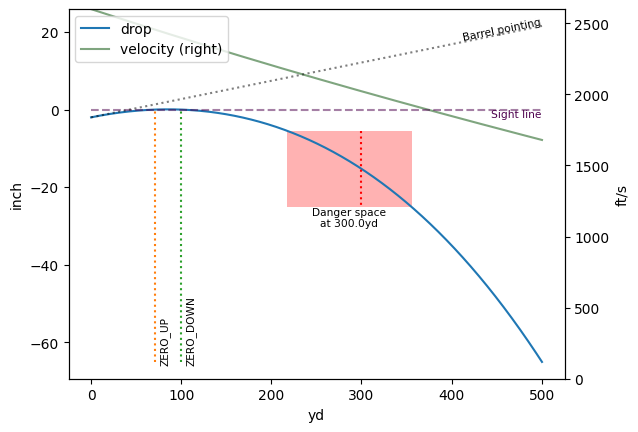

In [3]:
# Plot trajectory out to 500 yards
shot_result = calc.fire(zero, trajectory_range=500, extra_data=True)
ax = shot_result.plot()
# Find danger space for a half-meter tall target at 300 yards
danger_space = shot_result.danger_space(Distance.Yard(300), Distance.Meter(.5))
print(danger_space)
danger_space.overlay(ax)  # Highlight danger space on the plot
plt.show()

# Print Range Card

In [4]:
# Range card for this zero with 5mph cross-wind from left to right
zero.winds = [Wind(Velocity.MPH(5), Angular.OClock(3))]
range_card = calc.fire(zero, trajectory_range=1000)
# for p in range_card: print(p.formatted())
range_card.dataframe().to_clipboard()
range_card.dataframe(True).drop(['energy', 'ogw', 'flag'], axis=1)

,time,distance,velocity,mach,drop,drop_adj,windage,windage_adj,angle
0,0.00 s,0.0 yd,2600.0 ft/s,2.33 mach,-2.0 inch,0.00 mil,-0.0 inch,0.00 mil,0.0750 °
1,0.12 s,100.0 yd,2398.1 ft/s,2.15 mach,-0.0 inch,-0.00 mil,0.4 inch,0.12 mil,-0.0137 °
2,0.25 s,200.0 yd,2205.4 ft/s,1.98 mach,-4.1 inch,-0.57 mil,1.7 inch,0.25 mil,-0.1184 °
3,0.39 s,300.0 yd,2022.2 ft/s,1.81 mach,-15.3 inch,-1.44 mil,4.1 inch,0.39 mil,-0.2425 °
4,0.55 s,400.0 yd,1847.4 ft/s,1.65 mach,-35.0 inch,-2.48 mil,7.6 inch,0.54 mil,-0.3906 °
5,0.72 s,500.0 yd,1680.1 ft/s,1.50 mach,-65.0 inch,-3.68 mil,12.4 inch,0.70 mil,-0.5688 °
6,0.91 s,600.0 yd,1519.5 ft/s,1.36 mach,-107.3 inch,-5.06 mil,18.8 inch,0.89 mil,-0.7856 °
7,1.11 s,700.0 yd,1366.0 ft/s,1.22 mach,-164.8 inch,-6.66 mil,27.0 inch,1.09 mil,-1.0523 °
8,1.35 s,800.0 yd,1221.3 ft/s,1.09 mach,-240.9 inch,-8.52 mil,37.3 inch,1.32 mil,-1.3842 °
9,1.61 s,900.0 yd,1093.3 ft/s,0.98 mach,-340.5 inch,-10.71 mil,50.0 inch,1.57 mil,-1.8006 °


# Firing Solutions

## Different Distance, from Range Card

First approach here shows getting firing solution by looking up the adjustment in the Range Card:

In [6]:
# Now shooter is sighting a target at look-distance 500 yard (zero.look-angle):
new_target_distance = Distance.Yard(500)
# Get row for this distance from the range card
new_target = range_card.get_at_distance(new_target_distance)
print(f'Zero trajectory hits {new_target.drop << Set.Units.drop}'
      f' at {(new_target.distance << Set.Units.distance)}')

# Shooter looks up adjustment to hit new target:
hold = new_target.drop_adj  # << Firing solution

print(f'Sight adjustment to hit {(new_target.distance << Set.Units.distance)} target'
      f' is {(hold << Set.Units.adjustment)}')
# Shooter dials that hold value for a 500-yard shot.  Verification:
range_card.shot.relative_angle = Angular(-hold.unit_value, hold.units)
adjusted_result = calc.fire(range_card.shot, trajectory_range=1000)
trajectory_adjusted = adjusted_result.get_at_distance(new_target_distance)
print(f'After adjustment: drop at {trajectory_adjusted.distance << Set.Units.distance}'
      f' is {trajectory_adjusted.drop << Set.Units.drop}')

Zero trajectory hits -65.0inch at 500.0yd
Sight adjustment to hit 500.0yd target is -3.68mil
After adjustment: drop at 500.0yd is -0.0inch


## Different Look Angle

Second approach here shows solving for barrel elevation to hit new target, then adjusting by the difference between that and the zero barrel elevation:

To hit target at look-distance of 500.0yd sighted at a 30.0° look-angle, barrel elevation=4.39mil
Current zero has barrel elevated 1.33mil so hold for new shot is 3.05mil


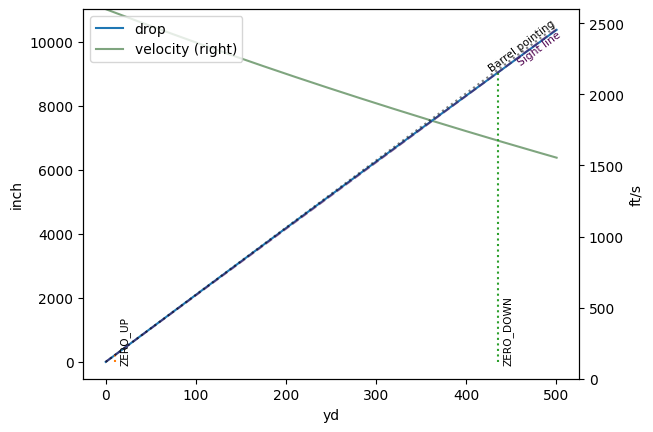

(Horizontal component of distance to this target is 433.0yd)


In [7]:
# Calculate elevation for a new shot at a different look-angle
new_shot = copy.copy(zero)  # Copy the zero properties; NB: Not a deepcopy!
new_shot.look_angle = Angular.Degree(30)
new_elevation = calc.barrel_elevation_for_target(shot=new_shot, target_distance=new_target_distance)
# Firing solution:
hold = Angular.Mil((new_elevation >> Angular.Mil) - (zero.weapon.zero_elevation >> Angular.Mil))

print(f'To hit target at look-distance of {new_target_distance << Set.Units.distance}'
      f' sighted at a {new_shot.look_angle << Set.Units.angular} look-angle,' 
      f' barrel elevation={new_elevation << Set.Units.adjustment}')
print(f'Current zero has barrel elevated {zero.weapon.zero_elevation << Set.Units.adjustment}'
      f' so hold for new shot is {hold << Set.Units.adjustment}')      

# Plot this shot
new_shot.relative_angle = hold
adjusted_result = calc.fire(new_shot, trajectory_range=500, extra_data=True)
adjusted_result.plot()
plt.show()

from math import cos
horizontal = Distance(cos(new_shot.look_angle >> Angular.Radian)
                      * new_target_distance.unit_value, new_target_distance.units)
print(f'(Horizontal component of distance to this target is {horizontal})')

# Change Defaults; Setup New Gun

Now we'll switch to metric units and:
* Define a standard .50BMG
* Enable and define Ammo model of powder temperature sensitivity.
* Zeroed for a distance of 500 meters, in a 5°C atmosphere at altitude 1000ft ASL.

In [13]:
Set.Units.distance = Unit.METER
Set.Units.velocity = Unit.MPS
Set.Units.drop = Unit.METER
Set.Units.sight_height = Unit.CENTIMETER
Set.USE_POWDER_SENSITIVITY = True

# Standard .50BMG
dm = DragModel(0.62, TableG1, 661, 0.51, 2.3)
ammo=Ammo(dm, 850, Temperature.Celsius(15))
ammo.calc_powder_sens(820, Temperature.Celsius(0))
weapon = Weapon(sight_height=9, twist=15)
# Cool and windy
atmo = Atmo(altitude=Distance.Foot(1000), temperature=Unit.CELSIUS(5), humidity=.5)
zero = Shot(weapon=weapon, ammo=ammo, atmo=atmo)
zero_distance = Distance.Meter(500)
calc = Calculator()
zero_elevation = calc.set_weapon_zero(zero, zero_distance)
print(f'Barrel elevation for {zero_distance} zero: {zero_elevation << Set.Units.adjustment}')
print(f'Muzzle velocity at zero temperature {atmo.temperature} is {ammo.get_velocity_for_temp(atmo.temperature) << Set.Units.velocity}')

Barrel elevation for 500.0m zero: 4.69mil
Muzzle velocity at zero temperature 5.0°C is 830.0m/s


To hit target at look-distance of 700.0m sighted at a 30.0° look-angle, barrel elevation=6.19mil
Current zero has barrel elevated 4.69mil so hold for new shot is 1.51mil
Danger space at 700.0m for 4.0m tall target at 30.0° look-angle ranges from 502.0m to 811.3m


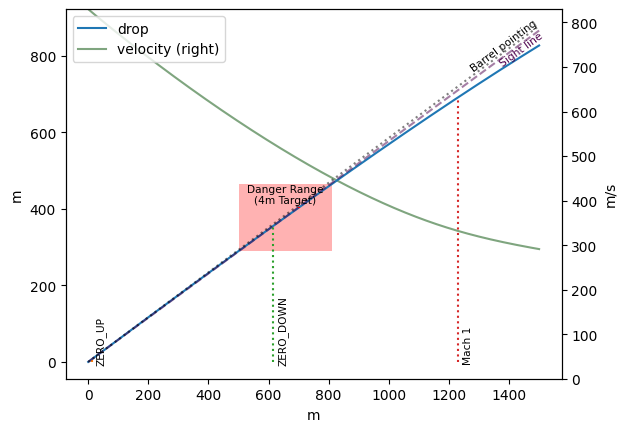

In [18]:
# Firing solution for 700m target at 30°
new_shot = copy.copy(zero)  # Copy the zero properties; NB: Not a deepcopy!
new_shot.look_angle = Angular.Degree(30)
new_target_distance = Distance.Meter(700)
new_elevation = calc.barrel_elevation_for_target(shot=new_shot, target_distance=new_target_distance)
print(f'To hit target at look-distance of {new_target_distance << Set.Units.distance}'
      f' sighted at a {new_shot.look_angle << Set.Units.angular} look-angle,' 
      f' barrel elevation={new_elevation << Set.Units.adjustment}')

# Firing solution:
hold = Angular.Mil((new_elevation >> Angular.Mil) - (zero.weapon.zero_elevation >> Angular.Mil))
print(f'Current zero has barrel elevated {zero.weapon.zero_elevation << Set.Units.adjustment}'
      f' so hold for new shot is {hold << Set.Units.adjustment}')      

# Plot this shot
new_shot.relative_angle = hold
adjusted_result = calc.fire(new_shot, trajectory_range=1500, extra_data=True)
ax = adjusted_result.plot()
# Find danger space for a 4-meter tall target
danger_space = adjusted_result.danger_space(at_range=new_target_distance,
                                        target_height=Distance.Meter(4),
                                        look_angle=new_shot.look_angle)
print(danger_space)
# Highlight danger space on the plot
danger_space.overlay(ax, 'Danger Range\n(4m Target)')
plt.show()

# Units

In [12]:
Set.Units.distance = Unit.FOOT
print(f'Default distance unit: {Set.Units.distance.name}')
# Can create value in default unit with either float or another unit of same type
print(f'\tInstantiated from float (5): {Set.Units.distance(5)}')
print(f'\tInstantiated from Distance.Line(200): {Set.Units.distance(Distance.Line(200))}')

# Ways to define value in units
# 1. old syntax
unit_in_meter = Distance(100, Distance.Meter)
# 2. short syntax by Unit type class
unit_in_meter = Distance.Meter(100)
# 3. by Unit enum class
unit_in_meter = Unit.METER(100)
print(f'100 meters: {unit_in_meter}')
# >>> 100 meters: 100.0m

# Convert unit
# 1. by .convert()
unit_in_yards = unit_in_meter.convert(Distance.Yard)
# 2. using shift syntax
unit_in_yards = unit_in_meter << Distance.Yard  # '<<=' operator also supports
print(f'100 meters in {unit_in_yards.units.key}: {unit_in_yards}')
# >>> 100 meters in yard: 109.4yd

# Get value in specified units (as float)
# 1. by .get_in()
value_in_km = unit_in_yards.get_in(Distance.Kilometer)
# 2. by shift syntax
value_in_km = unit_in_yards >> Distance.Kilometer  # '>>=' operator also supports
print(f'100 meters, value in km: {value_in_km}  (value type is {type(value_in_km)})')
# >>> 100 meters, value in km: 0.1  (value type is <class 'float'>)

# Getting unit raw value (a float)
rvalue = Distance.Meter(100).raw_value
rvalue = float(Distance.Meter(100))
print(f'100 meters in raw value: {rvalue}  (raw type is {type(rvalue)})')
# >>> 100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)

# Comparison operators supported: < > <= >= == !=
print(f'Comparison: {unit_in_meter} == {Distance.Centimeter(100)}: {unit_in_meter == Distance.Centimeter(100)}')  # >>> False, compare two units by raw value
print(f'Comparison: {unit_in_meter} > .1*{unit_in_meter}: {unit_in_meter > .1*unit_in_meter.raw_value}')  # >>> True, compare unit with float by raw value

Default distance unit: FOOT
	Instantiated from float (5): 5.0ft
	Instantiated from Distance.Line(200): 1.67ft
100 meters: 100.0m
100 meters in yard: 109.4yd
100 meters, value in km: 0.1  (value type is <class 'float'>)
100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)
Comparison: 100.0m == 100.0cm: False
Comparison: 100.0m > .1*100.0m: True
